# EEG E/I Balance Comparison - Enhanced Analysis

**Improvements from Notebook 1:**
- Pre/Post difference topomaps per subject (Post − Pre)
- Side-by-side PRE | POST | DIFFERENCE panels
- Clear subject labeling throughout all figures
- Spaghetti plots showing individual pre→post trajectories
- Offset extraction in addition to exponent
- Regional change heatmaps

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.lines import Line2D
from pathlib import Path
import mne
from scipy.signal import welch
from specparam import SpectralModel
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = Path('/Users/manasapooni/Downloads/TReC_EI_Cleaned')
OUTPUT_DIR = DATA_DIR / 'Analysis_Output_Enhanced'
OUTPUT_DIR.mkdir(exist_ok=True)
FREQ_RANGE = [1, 40]

# Standard 10-20 electrode positions (unit circle, nose at top)
ELECTRODE_POS = {
    'Fpz': (0.0, 0.9), 'AFz': (0.0, 0.72), 'Fz': (0.0, 0.54),
    'FCz': (0.0, 0.36), 'Cz': (0.0, 0.0), 'CPz': (0.0, -0.36),
    'Pz': (0.0, -0.54), 'POz': (0.0, -0.72), 'Oz': (0.0, -0.9),
    'Fp1': (-0.22, 0.88), 'AF3': (-0.28, 0.68), 'AF7': (-0.5, 0.68),
    'F1': (-0.18, 0.5), 'F3': (-0.36, 0.5), 'F5': (-0.54, 0.48), 'F7': (-0.72, 0.42),
    'FC1': (-0.18, 0.28), 'FC3': (-0.38, 0.26), 'FC5': (-0.58, 0.24), 'FT7': (-0.78, 0.2),
    'C1': (-0.22, 0.0), 'C3': (-0.44, 0.0), 'C5': (-0.66, 0.0), 'T7': (-0.88, 0.0),
    'CP1': (-0.18, -0.28), 'CP3': (-0.38, -0.26), 'CP5': (-0.58, -0.24), 'TP7': (-0.78, -0.2),
    'P1': (-0.18, -0.5), 'P3': (-0.36, -0.5), 'P5': (-0.54, -0.48), 'P7': (-0.72, -0.42),
    'PO3': (-0.28, -0.68), 'PO7': (-0.5, -0.68), 'O1': (-0.22, -0.88),
    'Fp2': (0.22, 0.88), 'AF4': (0.28, 0.68), 'AF8': (0.5, 0.68),
    'F2': (0.18, 0.5), 'F4': (0.36, 0.5), 'F6': (0.54, 0.48), 'F8': (0.72, 0.42),
    'FC2': (0.18, 0.28), 'FC4': (0.38, 0.26), 'FC6': (0.58, 0.24), 'FT8': (0.78, 0.2),
    'C2': (0.22, 0.0), 'C4': (0.44, 0.0), 'C6': (0.66, 0.0), 'T8': (0.88, 0.0),
    'CP2': (0.18, -0.28), 'CP4': (0.38, -0.26), 'CP6': (0.58, -0.24), 'TP8': (0.78, -0.2),
    'P2': (0.18, -0.5), 'P4': (0.36, -0.5), 'P6': (0.54, -0.48), 'P8': (0.72, -0.42),
    'PO4': (0.28, -0.68), 'PO8': (0.5, -0.68), 'O2': (0.22, -0.88),
}

BRAIN_LOBES = {
    'Frontal': ['Fp1', 'Fp2', 'Fpz', 'AF3', 'AF4', 'AFz', 'AF7', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
    'Motor': ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT7', 'FT8'],
    'Sensory': ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T7', 'T8'],
    'Parietal': ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
    'Occipital': ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2'],
}

# Subject styling
SUBJECT_COLORS = {'12237': '#e41a1c', '12454': '#377eb8', '803': '#4daf4a'}
SUBJECT_MARKERS = {'12237': 'o', '12454': 's', '803': '^'}

all_files = sorted(DATA_DIR.glob('*.set'))
print(f'Found {len(all_files)} files')

Found 9 files


---
## Helper Functions

In [2]:
def parse_filename(filename):
    """Parse filename to extract subject ID and condition."""
    name = filename.stem if hasattr(filename, 'stem') else str(filename)
    name_lower = name.lower()
    
    # Extract subject ID
    subject_id = None
    for sid in ['12237', '12454', '803']:
        if sid in name:
            subject_id = sid
            break
    
    # Determine condition
    condition = 'post' if 'post' in name_lower else ('pre' if 'pre' in name_lower else 'unknown')
    
    # Identify variants
    variant = 'standard'
    if 'nooffset' in name_lower:
        variant = 'nooffset'
    elif 'notimestamp' in name_lower:
        variant = 'notimestamps'
    
    clean_label = f"Subj {subject_id} - {condition.upper()}"
    if variant != 'standard':
        clean_label += f" ({variant})"
    
    return {
        'subject_id': subject_id,
        'condition': condition,
        'variant': variant,
        'clean_label': clean_label,
        'original_name': name
    }


def compute_exponents(filepath):
    """Compute aperiodic exponents AND offsets from EEG file."""
    raw = mne.io.read_raw_eeglab(str(filepath), preload=True, verbose=False)
    fs = raw.info['sfreq']
    data = raw.get_data()
    n_fft = min(int(2 * fs), data.shape[1])
    
    exponents = {}
    offsets = {}
    
    for i, ch in enumerate(raw.ch_names):
        f, pxx = welch(data[i], fs=fs, nperseg=n_fft, noverlap=n_fft//2)
        mask = (f >= 1) & (f <= 50)
        try:
            sm = SpectralModel(peak_width_limits=[1, 12], max_n_peaks=5, 
                             aperiodic_mode='fixed', verbose=False)
            sm.fit(f[mask], pxx[mask], FREQ_RANGE)
            ap = sm.get_params('aperiodic')
            if ap is not None and len(ap) >= 2:
                offsets[ch] = ap[0]
                exponents[ch] = ap[1]
            else:
                offsets[ch] = np.nan
                exponents[ch] = np.nan
        except:
            offsets[ch] = np.nan
            exponents[ch] = np.nan
    
    # Regional averages
    lobe_exp, lobe_off = {}, {}
    for lobe, chs in BRAIN_LOBES.items():
        exp_vals = [exponents.get(ch, np.nan) for ch in chs if not np.isnan(exponents.get(ch, np.nan))]
        off_vals = [offsets.get(ch, np.nan) for ch in chs if not np.isnan(offsets.get(ch, np.nan))]
        lobe_exp[lobe] = np.mean(exp_vals) if exp_vals else np.nan
        lobe_off[lobe] = np.mean(off_vals) if off_vals else np.nan
    
    return (exponents, offsets, lobe_exp, lobe_off, 
            np.nanmean(list(exponents.values())), np.nanmean(list(offsets.values())))


def compute_channel_difference(pre_channels, post_channels):
    """Compute post - pre difference for each channel."""
    diff = {}
    for ch in set(pre_channels.keys()) | set(post_channels.keys()):
        pre_val = pre_channels.get(ch, np.nan)
        post_val = post_channels.get(ch, np.nan)
        if not np.isnan(pre_val) and not np.isnan(post_val):
            diff[ch] = post_val - pre_val
        else:
            diff[ch] = np.nan
    return diff

---
## Plotting Functions

In [3]:
def plot_topo(exponents, title='', vmin=None, vmax=None, ax=None, 
              show_regions=True, cmap='RdBu_r', diverging=False, center=0):
    """Plot topographic electrode map with brain region labels."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.figure
    
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw brain region backgrounds
    if show_regions:
        ax.add_patch(Wedge((0, 0), 0.98, 50, 130, width=0.55, facecolor='#e3f2fd', alpha=0.4, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.45, 40, 140, width=0.45, facecolor='#fff3e0', alpha=0.4, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.5, 140, 40, width=0.5, facecolor='#f3e5f5', alpha=0.3, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.75, 220, 320, width=0.4, facecolor='#e8f5e9', alpha=0.4, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.98, 230, 310, width=0.35, facecolor='#fce4ec', alpha=0.4, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.98, 140, 220, width=0.3, facecolor='#fff8e1', alpha=0.4, zorder=0))
        ax.add_patch(Wedge((0, 0), 0.98, 320, 40, width=0.3, facecolor='#fff8e1', alpha=0.4, zorder=0))
        
        ax.text(0, 0.75, 'Frontal', fontsize=7, ha='center', color='#1565c0', fontweight='bold', alpha=0.6, zorder=1)
        ax.text(0, 0.32, 'Motor', fontsize=6, ha='center', color='#e65100', fontweight='bold', alpha=0.6, zorder=1)
        ax.text(0, 0.0, 'Sensory', fontsize=6, ha='center', color='#7b1fa2', fontweight='bold', alpha=0.6, zorder=1)
        ax.text(0, -0.42, 'Parietal', fontsize=7, ha='center', color='#2e7d32', fontweight='bold', alpha=0.6, zorder=1)
        ax.text(0, -0.82, 'Occipital', fontsize=7, ha='center', color='#c2185b', fontweight='bold', alpha=0.6, zorder=1)
        ax.text(-0.85, 0.0, 'T', fontsize=6, ha='center', color='#f9a825', fontweight='bold', alpha=0.7, zorder=1)
        ax.text(0.85, 0.0, 'T', fontsize=6, ha='center', color='#f9a825', fontweight='bold', alpha=0.7, zorder=1)
    
    # Head outline
    ax.add_patch(Circle((0, 0), 1.0, fill=False, edgecolor='#333', linewidth=2, zorder=5))
    ax.plot([0, -0.08, 0.08, 0], [1.1, 1.0, 1.0, 1.1], color='#333', linewidth=2, zorder=5)
    ax.add_patch(Wedge((-1.0, 0), 0.1, 90, 270, fill=False, edgecolor='#333', linewidth=2, zorder=5))
    ax.add_patch(Wedge((1.0, 0), 0.1, -90, 90, fill=False, edgecolor='#333', linewidth=2, zorder=5))
    
    # Color scale
    vals = [v for v in exponents.values() if not np.isnan(v)]
    if vmin is None:
        vmin = np.percentile(vals, 5) if vals else -0.5
    if vmax is None:
        vmax = np.percentile(vals, 95) if vals else 0.5
    
    colormap = plt.cm.get_cmap(cmap)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax) if diverging else Normalize(vmin=vmin, vmax=vmax)
    
    # Draw electrodes
    for ch, (x, y) in ELECTRODE_POS.items():
        val = exponents.get(ch, np.nan)
        if not np.isnan(val):
            color = colormap(norm(val))
            ax.add_patch(Circle((x, y), 0.052, facecolor=color, edgecolor='#333', linewidth=0.8, zorder=10))
    
    if title:
        ax.set_title(title, fontsize=11, fontweight='bold', pad=8)
    
    return fig, ax, norm, colormap

---
## Process All Files

In [4]:
# Parse and process files
file_info = {}
for f in all_files:
    info = parse_filename(f)
    info['filepath'] = f
    file_info[f.stem] = info

print('Parsed files:')
for name, info in file_info.items():
    print(f'  {name} → Subj {info["subject_id"]}, {info["condition"].upper()}, {info["variant"]}')

Parsed files:
  TReC_12237_preEEG_EI → Subj 12237, PRE, standard
  TReC_12454_PostEEG_EI_notimestamps (1) → Subj 12454, POST, notimestamps
  TReC_12454_postEEG_EI → Subj 12454, POST, standard
  TReC_12454_preEEG_EI → Subj 12454, PRE, standard
  TReC_12454_preEEG_EI_nooffset → Subj 12454, PRE, nooffset
  TReC_803_PreEEG → Subj 803, PRE, standard
  TReC_803_postEEG_EI → Subj 803, POST, standard
  TReC_803_preEEG_EI → Subj 803, PRE, standard
  TRec_12237_EI_post → Subj 12237, POST, standard


In [5]:
# Compute exponents for all files
results = {}
for name, info in file_info.items():
    print(f'Processing {info["clean_label"]}...')
    try:
        ch_exp, ch_off, lobe_exp, lobe_off, glob_exp, glob_off = compute_exponents(info['filepath'])
        results[name] = {
            'info': info,
            'channels': ch_exp,
            'offsets': ch_off,
            'lobes': lobe_exp,
            'lobe_off': lobe_off,
            'global_exp': glob_exp,
            'global_off': glob_off,
        }
        print(f'  Global Exp: {glob_exp:.4f}, Offset: {glob_off:.4f}')
    except Exception as e:
        print(f'  ERROR: {e}')

print(f'\nDone: {len(results)} files processed')

Processing Subj 12237 - PRE...
  Global Exp: 1.1777, Offset: -11.1784
Processing Subj 12454 - POST (notimestamps)...
  Global Exp: 1.3693, Offset: -10.6461
Processing Subj 12454 - POST...
  Global Exp: 1.3791, Offset: -10.6378
Processing Subj 12454 - PRE...
  Global Exp: 1.2941, Offset: -10.8244
Processing Subj 12454 - PRE (nooffset)...
  Global Exp: 1.2157, Offset: -10.6462
Processing Subj 803 - PRE...
  Global Exp: 1.7129, Offset: -10.0651
Processing Subj 803 - POST...
  Global Exp: 1.5380, Offset: -10.5675
Processing Subj 803 - PRE...
  Global Exp: 1.2733, Offset: -12.7230
Processing Subj 12237 - POST...
  Global Exp: 1.2732, Offset: -10.9533

Done: 9 files processed


In [6]:
# Match pre/post pairs (standard variants only)
subject_pairs = {}

for sid in ['12237', '12454', '803']:
    pre_file, post_file = None, None
    
    for name, data in results.items():
        if data['info']['subject_id'] == sid and data['info']['variant'] == 'standard':
            if data['info']['condition'] == 'pre':
                if pre_file is None or 'EI' in name:
                    pre_file = name
            elif data['info']['condition'] == 'post':
                if post_file is None or 'EI' in name:
                    post_file = name
    
    if pre_file and post_file:
        subject_pairs[sid] = {'pre': results[pre_file], 'post': results[post_file]}
        print(f'Subject {sid}: PRE={pre_file}, POST={post_file}')

print(f'\n{len(subject_pairs)} complete pairs found')

Subject 12237: PRE=TReC_12237_preEEG_EI, POST=TRec_12237_EI_post
Subject 12454: PRE=TReC_12454_preEEG_EI, POST=TReC_12454_postEEG_EI
Subject 803: PRE=TReC_803_preEEG_EI, POST=TReC_803_postEEG_EI

3 complete pairs found


---
## Block Comparisons

In [ ]:
def segment_by_blocks(raw, block_onset='block_onset', block_offset='block_offset', first_block='rest'):
    """
    Segment raw data into alternating rest and suppress blocks, using onset/offset pairs.

    Interpretation:
      - Each block is defined ONLY by [block_onset_i, block_offset_i)
      - The time between block_offset_i and block_onset_{i+1} is ignored (unlabeled/random)
      - Blocks alternate type by order: block 0, 1, 2, ...
        first_block controls whether block 0 is labeled 'rest' or 'suppress'. -> this makes it modifiable if data recording is different for any sessions 

    Returns
    -------
    dict with keys:
        'rest': mne.io.Raw concatenated rest segments
        'suppress': mne.io.Raw concatenated suppress segments
        'rest_times': list of (start, end) tuples
        'suppress_times': list of (start, end) tuples
    """
    # Extract marker times
    onset_times = sorted([
        onset for desc, onset in zip(raw.annotations.description, raw.annotations.onset)
        if block_onset.lower() in desc.lower()
    ])
    offset_times = sorted([
        onset for desc, onset in zip(raw.annotations.description, raw.annotations.onset)
        if block_offset.lower() in desc.lower()
    ])

    if len(onset_times) == 0 or len(offset_times) == 0:
        print(f"Warning: Found {len(onset_times)} onsets and {len(offset_times)} offsets.")
        return None

    # Pair each onset with the next offset after it (end of that same block)
    block_pairs = []
    j = 0
    for onset in onset_times:
        while j < len(offset_times) and offset_times[j] <= onset:
            j += 1
        if j >= len(offset_times):
            break
        offset = offset_times[j]
        if offset > onset:
            block_pairs.append((onset, offset))
        j += 1

    if len(block_pairs) == 0:
        print("Warning: Could not form any (onset, offset) block pairs.")
        return None

    # Split alternating blocks into rest vs suppress
    rest_times = []
    suppress_times = []

    first_is_rest = (first_block.lower() == 'rest')
    for idx, (t0, t1) in enumerate(block_pairs):
        if (idx % 2 == 0 and first_is_rest) or (idx % 2 == 1 and not first_is_rest):
            rest_times.append((t0, t1))
        else:
            suppress_times.append((t0, t1))

    # Extract and concatenate segments
    def concat_segments(raw, times):
        raws = []
        for tmin, tmax in times:
            tmax = min(tmax, raw.times[-1])
            if tmin < tmax:
                raws.append(raw.copy().crop(tmin=tmin, tmax=tmax))
        if not raws:
            return None
        return mne.concatenate_raws(raws) if len(raws) > 1 else raws[0]

    return {
        'rest': concat_segments(raw, rest_times),
        'suppress': concat_segments(raw, suppress_times),
        'rest_times': rest_times,
        'suppress_times': suppress_times
    }

def compute_condition_psd_from_segments(
    segments,
    fmin=1,
    fmax=40,
    n_fft_sec=2.0,
    n_overlap_frac=0.5,
    average="mean",
    picks="eeg",
    verbose=False
):
    """
    Compute Welch PSD for each condition in segments dict from segment_by_blocks.

    Parameters
    ----------
    segments : dict
        Output of segment_by_blocks with keys 'rest' and 'suppress' (Raw objects).
    fmin, fmax : float
        Frequency range for PSD.
    n_fft_sec : float
        Window length in seconds for Welch (n_fft = sfreq * n_fft_sec).
    n_overlap_frac : float
        Fraction overlap between windows (0..1). n_overlap = n_per_seg * frac.
    average : str
        'mean' or 'median' (MNE supports both depending on version).
    picks : str | list
        Which channels to use, default 'eeg'.

    Returns
    -------
    psd_results : dict
        psd_results[cond] = {'psd': (n_ch, n_freq), 'freqs': (n_freq,), 'ch_names': [...]}
    """
    psd_results = {}

    for cond in ("rest", "suppress"):
        raw_cond = segments.get(cond, None)
        if raw_cond is None:
            continue

        sfreq = raw_cond.info["sfreq"]
        n_fft = int(round(sfreq * n_fft_sec))
        n_per_seg = n_fft
        n_overlap = int(round(n_per_seg * n_overlap_frac))

        psd, freqs = mne.time_frequency.psd_welch(
            raw_cond,
            fmin=fmin,
            fmax=fmax,
            n_fft=n_fft,
            n_per_seg=n_per_seg,
            n_overlap=n_overlap,
            average=average,
            picks=picks,
            verbose=verbose
        )
        # psd shape: (n_channels, n_freqs)
        ch_names = [raw_cond.ch_names[i] for i in mne.pick_types(raw_cond.info, eeg=True, meg=False, seeg=False, ecog=False, stim=False, eog=False, emg=False, exclude=[])]

        psd_results[cond] = {
            "psd": psd,
            "freqs": freqs,
            "ch_names": ch_names,
            "sfreq": sfreq
        }

    return psd_results

def fit_aperiodic_from_psd(
    psd_results,
    output_root=None,
    pid=None,
    session_label=None,
    freq_range=(1, 40),
    conditions=("rest", "suppress"),
    aperiodic_mode="fixed",   # 'fixed' or 'knee'
    peak_width_limits=(1, 12),
    max_n_peaks=6,
    min_peak_height=0.1,
    peak_threshold=2.0,
    verbose=False
):
    """
    Fit aperiodic exponent per channel for each condition using SpecParam.

    Parameters
    ----------
    psd_results : dict
        psd_results[cond] must contain:
            - 'psd': np.ndarray (n_channels, n_freqs)
            - 'freqs': np.ndarray (n_freqs,)
            - 'ch_names': list[str]
    output_root : str | None
        If provided (and pid/session_label provided), saves per-channel CSV.
    pid, session_label : any
        Used for labeling/saving outputs.
    freq_range : tuple(float, float)
        Frequency range to fit within.
    conditions : tuple[str]
        Conditions to fit, typically ('rest','suppress').
    aperiodic_mode : str
        'fixed' or 'knee'.
    verbose : bool
        Print fit errors / warnings.

    Returns
    -------
    fit_out : dict
        For each condition, includes:
            - f"{cond}_exponent_by_channel": {channel: exponent}
            - f"{cond}_global": mean exponent across channels (nan-safe)
        Also includes:
            - 'per_channel_df': DataFrame with rows for all channels/conditions
            - optionally 'per_channel_csv': saved CSV path
    """
    rows = []
    fit_out = {}

    for cond in conditions:
        if cond not in psd_results:
            continue

        freqs = psd_results[cond]["freqs"]
        psd = psd_results[cond]["psd"]
        ch_names = psd_results[cond]["ch_names"]

        if psd.ndim != 2:
            raise ValueError(
                f"Expected psd to be 2D (n_channels, n_freqs). Got shape {psd.shape} for condition '{cond}'."
            )

        exponent_by_ch = {}

        for ci, ch in enumerate(ch_names):
            p = psd[ci, :]

            # SpecParam expects finite, positive power values
            if (not np.isfinite(p).all()) or np.any(p <= 0):
                if verbose:
                    print(f"[{pid} {session_label} {cond}] Invalid PSD values in {ch}; exponent=nan.")
                exponent = np.nan
                offset = np.nan
                r2 = np.nan
                error = np.nan
            else:
                try:
                    sm = SpectralModel(
                        aperiodic_mode=aperiodic_mode,
                        peak_width_limits=peak_width_limits,
                        max_n_peaks=max_n_peaks,
                        min_peak_height=min_peak_height,
                        peak_threshold=peak_threshold,
                        verbose=verbose
                    )
                    sm.fit(freqs, p, freq_range)

                    ap = sm.get_params("aperiodic_params")  # [offset, exponent] or [offset, knee, exponent]
                    if aperiodic_mode == "knee":
                        offset, knee, exponent = ap
                    else:
                        offset, exponent = ap

                    r2 = sm.get_params("r_squared")
                    error = sm.get_params("error")

                except Exception as e:
                    if verbose:
                        print(f"[{pid} {session_label} {cond}] Fit failed for {ch}: {e}")
                    exponent = np.nan
                    offset = np.nan
                    r2 = np.nan
                    error = np.nan

            exponent_by_ch[ch] = exponent

            rows.append({
                "pid": pid,
                "session": session_label,
                "condition": cond,
                "channel": ch,
                "exponent": exponent,
                "offset": offset,
                "r2": r2,
                "error": error,
            })

        fit_out[f"{cond}_exponent_by_channel"] = exponent_by_ch
        fit_out[f"{cond}_global"] = float(np.nanmean(list(exponent_by_ch.values()))) if exponent_by_ch else np.nan

    per_channel_df = pd.DataFrame(rows)
    fit_out["per_channel_df"] = per_channel_df

    # Optional save
    if output_root is not None and pid is not None and session_label is not None:
        os.makedirs(output_root, exist_ok=True)
        out_csv = os.path.join(output_root, f"{pid}_{session_label}_aperiodic_exponents_by_channel.csv")
        per_channel_df.to_csv(out_csv, index=False)
        fit_out["per_channel_csv"] = out_csv

    return fit_out


In [ ]:
## Example Usage of functions (for 12237_pre): can use this for troubleshooting 

pre_result_12237 = segment_by_blocks(pre_12237, 'block_onset', 'block_offset', first_block='rest')

# Step 1: PSD per condition (per channel)
psd_results = compute_condition_psd_from_segments(pre_result_12237, fmin=1, fmax=40)

# Step 2: Fit aperiodic exponent per channel, and global mean
fit_out = fit_aperiodic_from_psd(
    psd_results,
    output_root=OUTPUT_DIR,
    pid="12237",
    session_label="pre",
    freq_range=(1, 40),
    conditions=("rest", "suppress"),
    aperiodic_mode="fixed",
    verbose=False
)

# Access results
rest_exponents_by_ch = fit_out["rest_exponent_by_channel"]
rest_global = fit_out["rest_global"]

supp_exponents_by_ch = fit_out["suppress_exponent_by_channel"]
supp_global = fit_out["suppress_global"]

df_channel = fit_out["per_channel_df"]

In [ ]:
## Loop over all subjects 

all_global = []
all_channel = []

for sid, pair in subject_pairs.items():
    print(f"\n===== Subject {sid} =====")

    for sess in ("pre", "post"):
        entry = pair.get(sess, None)
        if entry is None:
            continue

        # CHANGE THIS LINE IF YOUR RAW IS STORED UNDER A DIFFERENT KEY
        raw = entry["raw"]   # or entry["data"], or entry itself

        segments = segment_by_blocks(
            raw,
            block_onset="block_onset",
            block_offset="block_offset",
            first_block="rest"
        )
        if segments is None:
            continue

        psd_results = compute_condition_psd_from_segments(
            segments,
            fmin=1,
            fmax=40,
            n_fft_sec=2.0,
            n_overlap_frac=0.5,
            average="mean",
            verbose=False
        )
        if len(psd_results) == 0:
            continue

        fit_out = fit_aperiodic_from_psd(
            psd_results,
            output_root=OUTPUT_DIR,
            pid=sid,
            session_label=sess,
            freq_range=(1, 40),
            conditions=("rest", "suppress"),
            aperiodic_mode="fixed",
            verbose=False
        )

        # Global mean exponents
        all_global.append({
            "pid": sid,
            "session": sess,
            "rest_global": fit_out.get("rest_global", np.nan),
            "suppress_global": fit_out.get("suppress_global", np.nan),
        })

        # Per-channel rows
        all_channel.append(fit_out["per_channel_df"])

# Save outputs
global_df = pd.DataFrame(all_global)
global_df.to_csv(os.path.join(OUTPUT_DIR, "aperiodic_exponents_summary.csv"), index=False)

channel_df = pd.concat(all_channel, ignore_index=True) if len(all_channel) else pd.DataFrame()
channel_df.to_csv(os.path.join(OUTPUT_DIR, "aperiodic_exponents_by_channel_all.csv"), index=False)

---
## Individual Topomaps (with Clear Subject Labels)

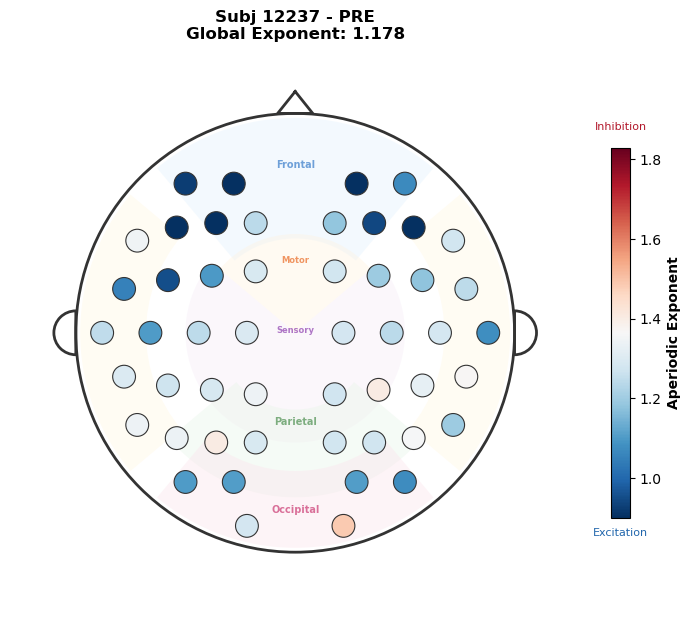

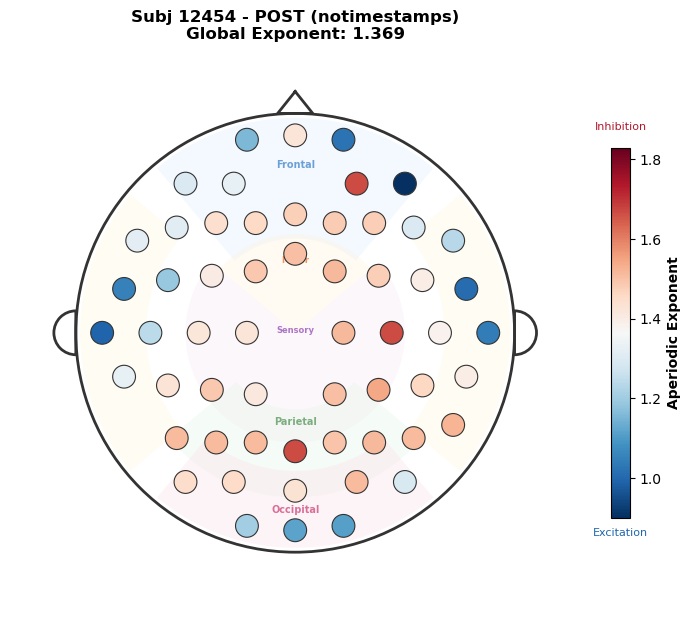

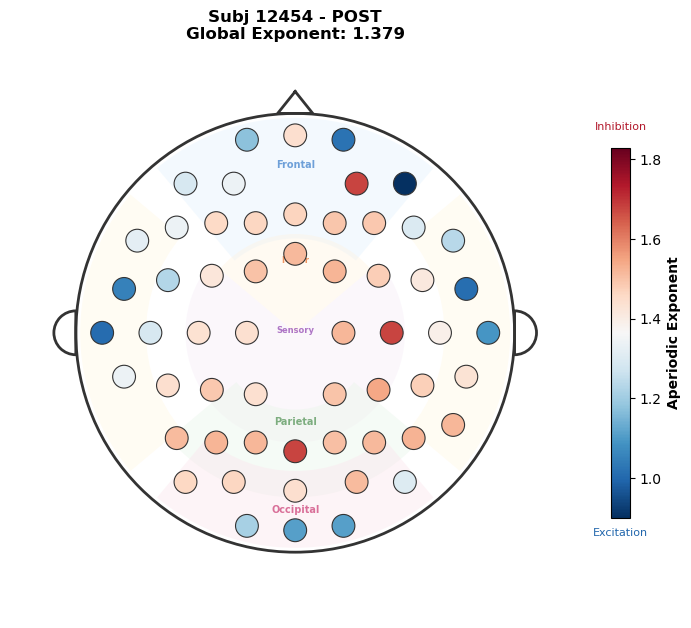

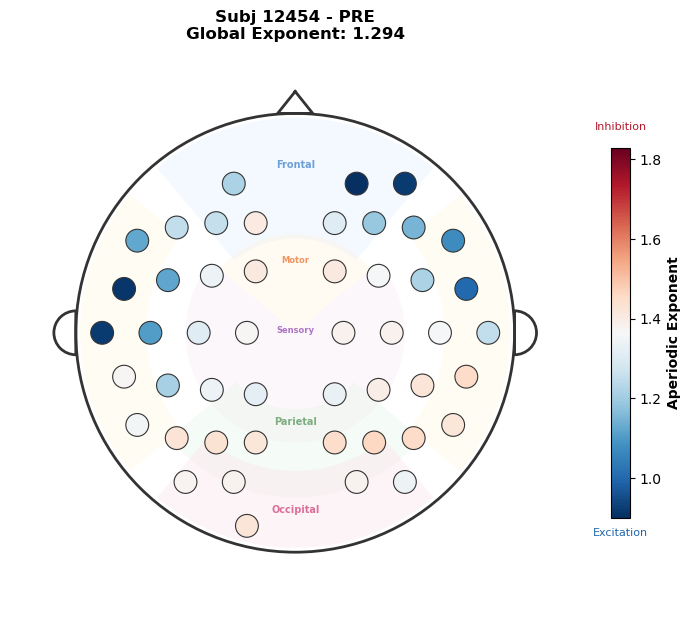

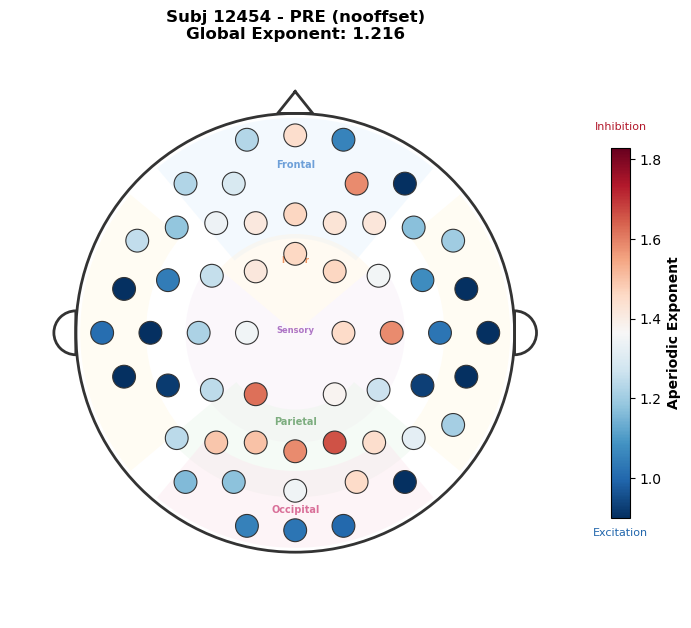

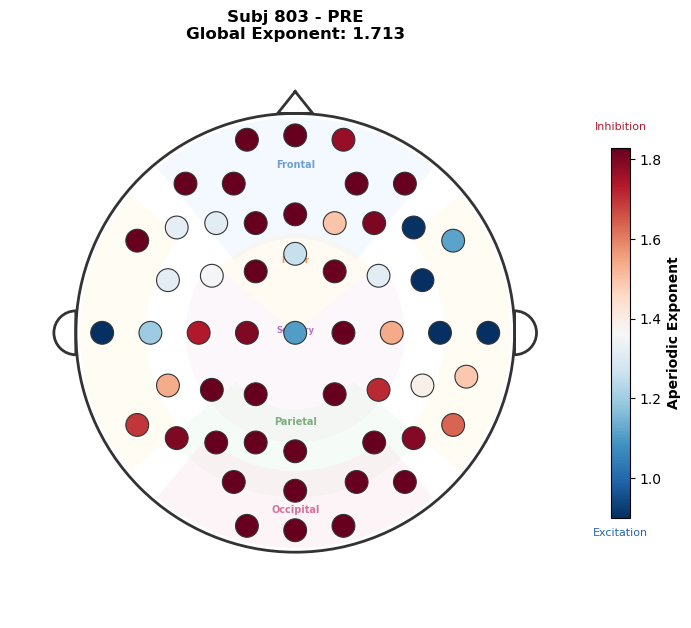

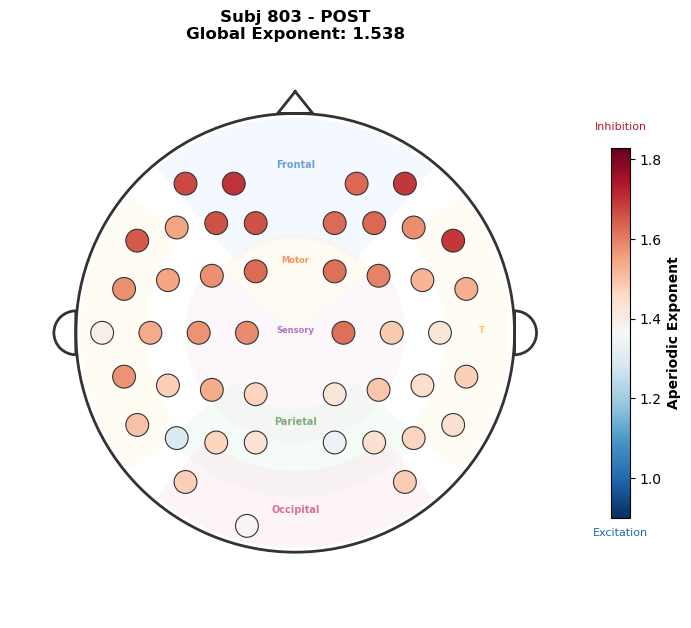

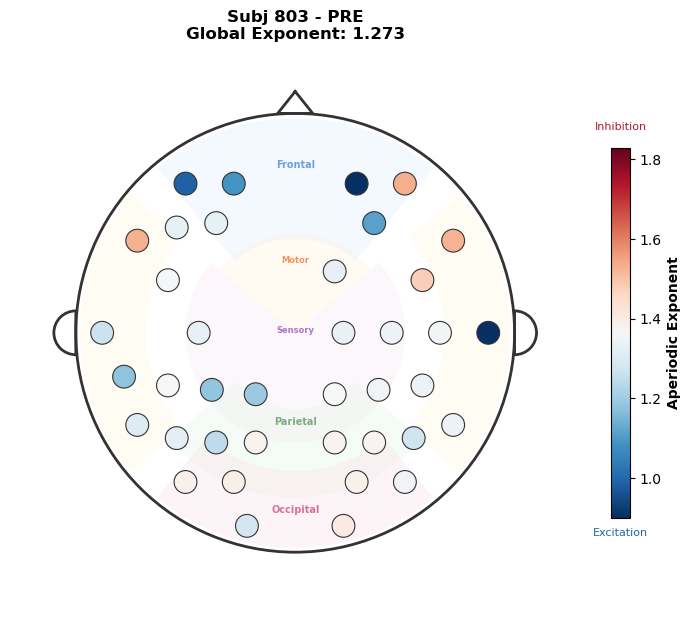

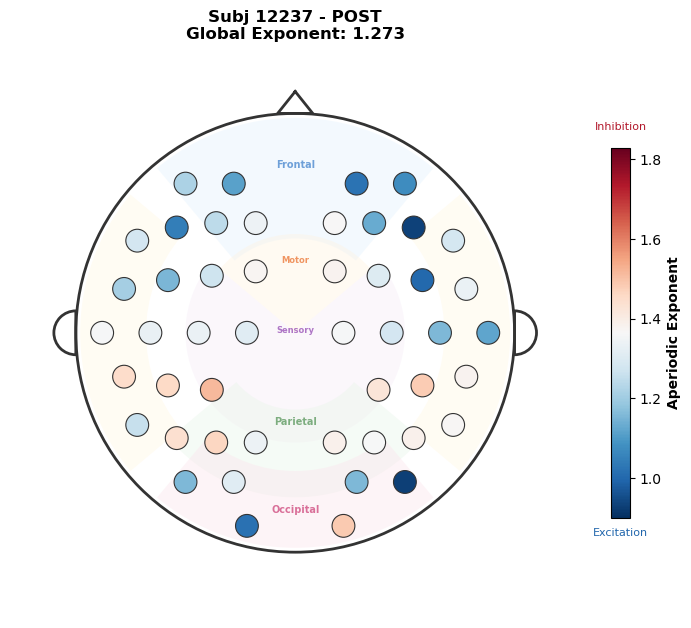

In [7]:
# Get global color scale
all_vals = []
for data in results.values():
    all_vals.extend([v for v in data['channels'].values() if not np.isnan(v)])
vmin, vmax = np.percentile(all_vals, [5, 95]) if all_vals else (1.0, 2.0)

# Generate individual plots with CLEAR LABELS
for name, data in results.items():
    fig, ax, norm, cmap = plot_topo(data['channels'], vmin=vmin, vmax=vmax)
    
    # CLEAR TITLE with Subject ID and Condition
    ax.set_title(f"{data['info']['clean_label']}\nGlobal Exponent: {data['global_exp']:.3f}", 
                 fontsize=12, fontweight='bold')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, shrink=0.6)
    cbar.set_label('Aperiodic Exponent', fontsize=10, fontweight='bold')
    cbar.ax.text(0.5, -0.05, 'Excitation', transform=cbar.ax.transAxes, fontsize=8, ha='center', color='#2166ac')
    cbar.ax.text(0.5, 1.05, 'Inhibition', transform=cbar.ax.transAxes, fontsize=8, ha='center', color='#b2182b')
    
    plt.savefig(OUTPUT_DIR / f'topo_{name}.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()

---
## PRE | POST | DIFFERENCE Panels (Per Subject)

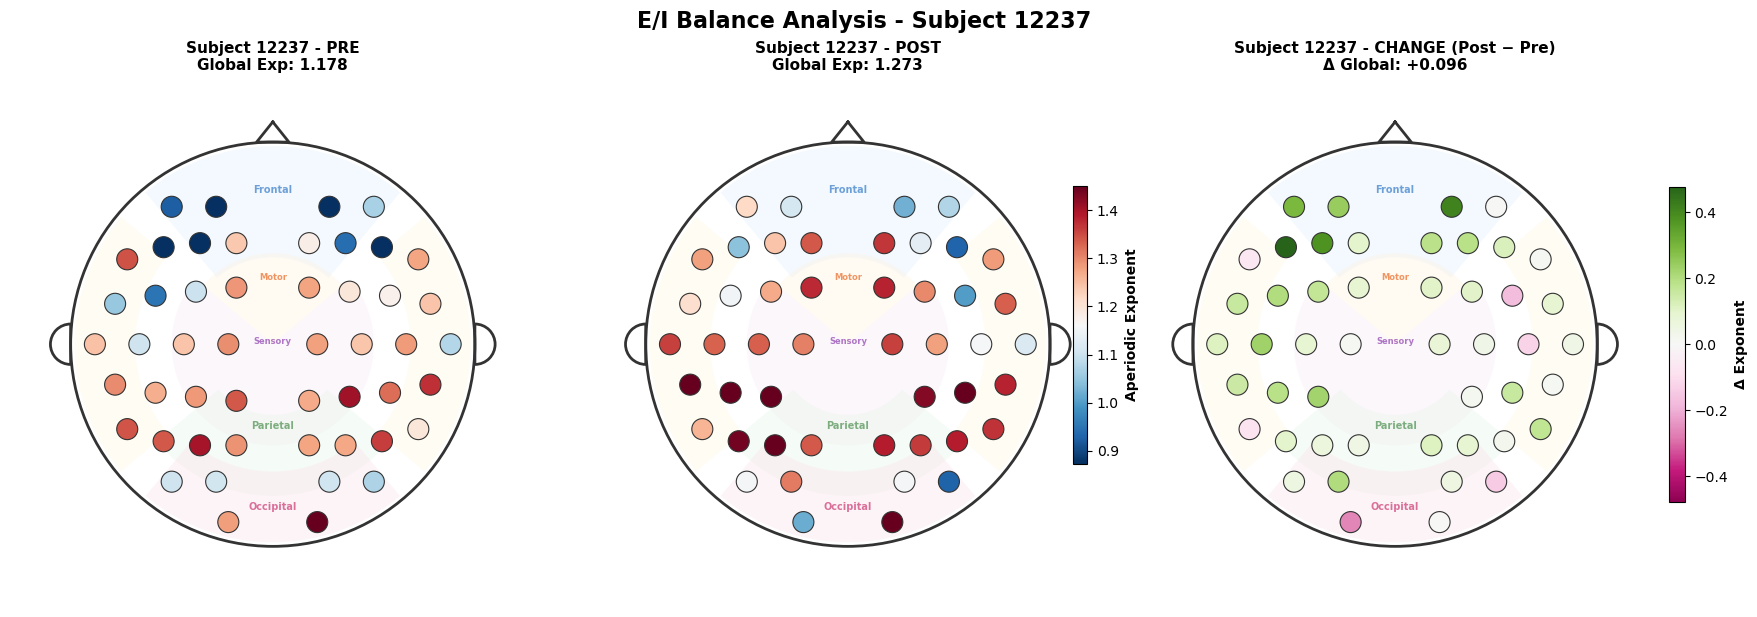

Saved: pre_post_diff_subj_12237.png


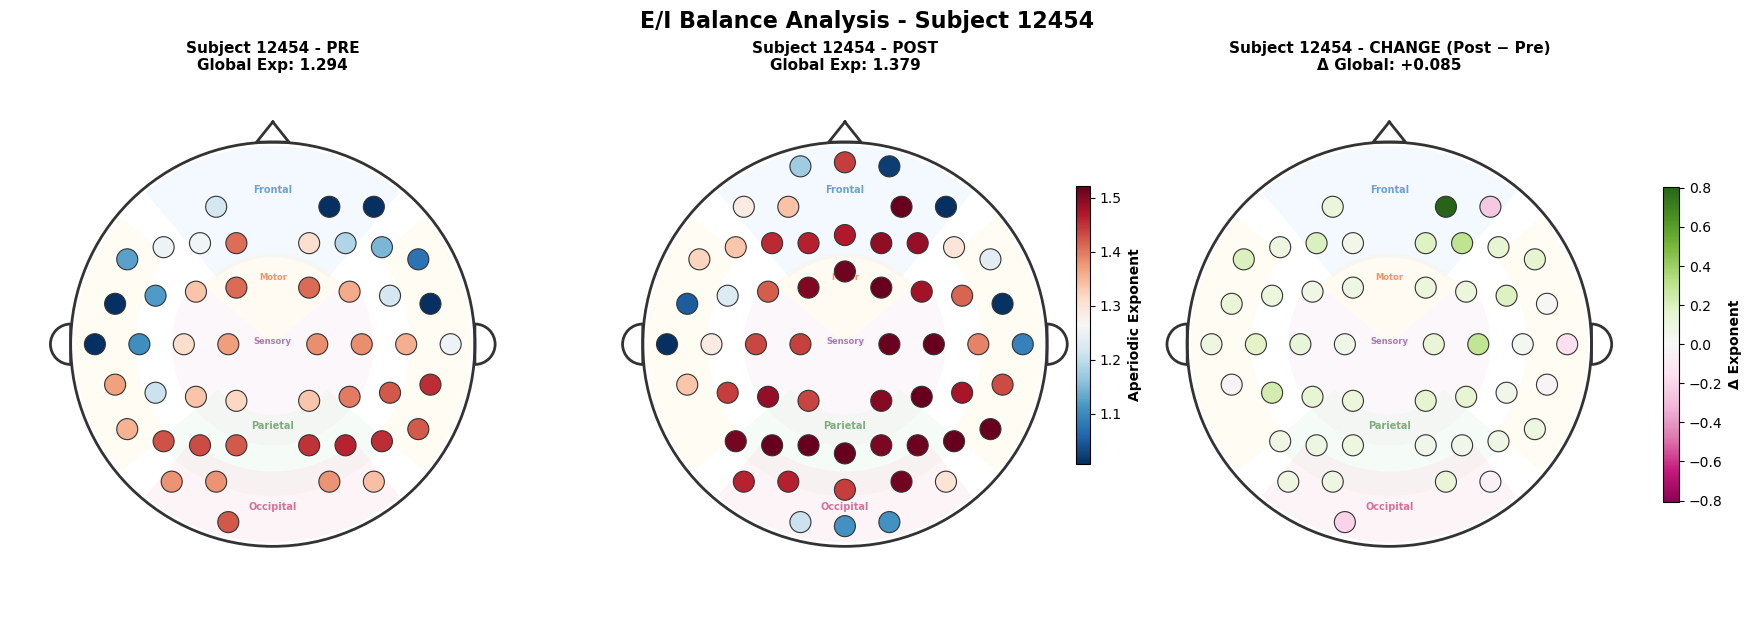

Saved: pre_post_diff_subj_12454.png


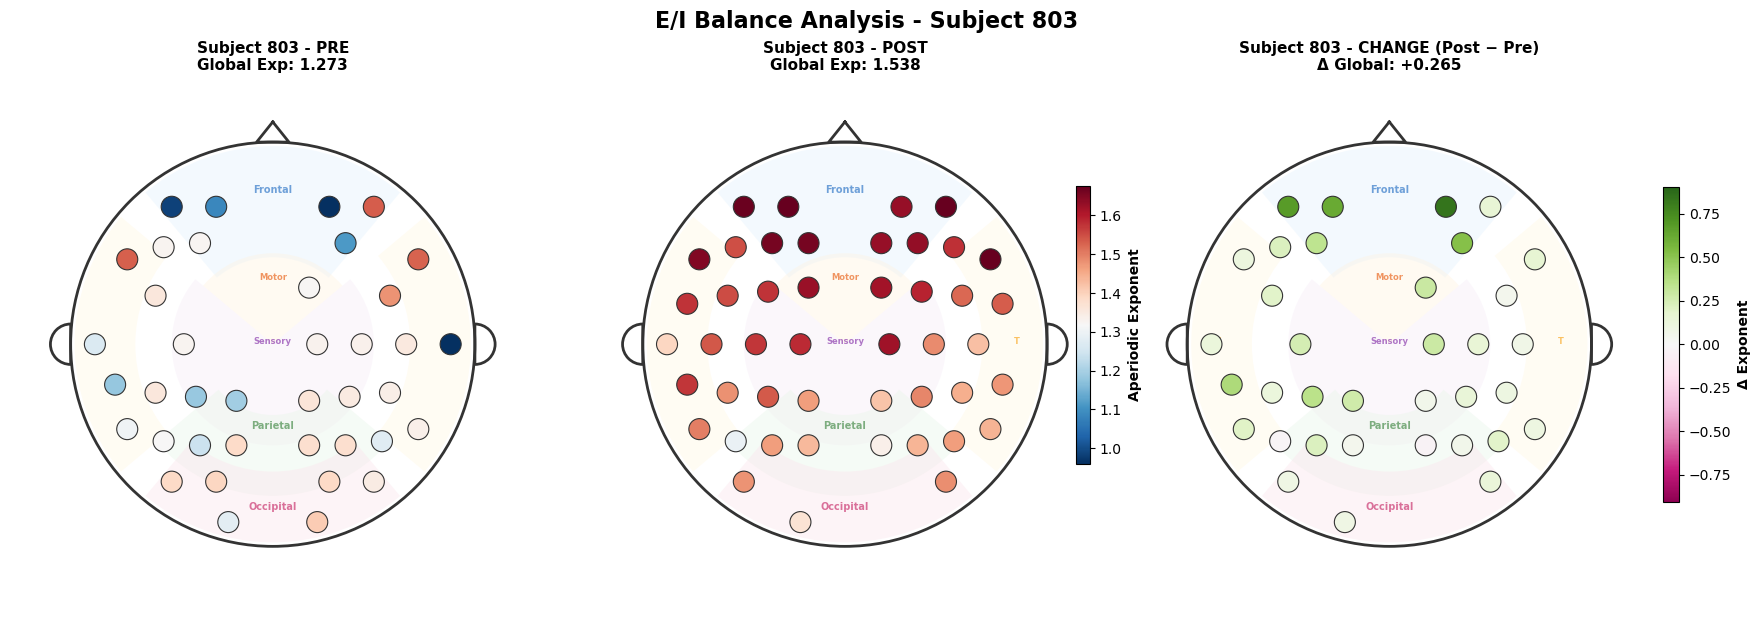

Saved: pre_post_diff_subj_803.png


In [8]:
def plot_pre_post_diff_panels(subject_id, pre_data, post_data):
    """Create 3-panel figure: PRE | POST | DIFFERENCE for a single subject."""
    
    # Compute difference
    diff_channels = compute_channel_difference(pre_data['channels'], post_data['channels'])
    
    # Color scales
    all_vals = list(pre_data['channels'].values()) + list(post_data['channels'].values())
    all_vals = [v for v in all_vals if not np.isnan(v)]
    vmin_abs = np.percentile(all_vals, 5) if all_vals else 1.0
    vmax_abs = np.percentile(all_vals, 95) if all_vals else 2.0
    
    diff_vals = [v for v in diff_channels.values() if not np.isnan(v)]
    if diff_vals:
        max_diff = max(abs(min(diff_vals)), abs(max(diff_vals)))
        vmin_diff, vmax_diff = -max_diff, max_diff
    else:
        vmin_diff, vmax_diff = -0.3, 0.3
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PRE panel
    _, _, norm_pre, cmap_pre = plot_topo(
        pre_data['channels'], 
        title=f"Subject {subject_id} - PRE\nGlobal Exp: {pre_data['global_exp']:.3f}",
        vmin=vmin_abs, vmax=vmax_abs, ax=axes[0], cmap='RdBu_r'
    )
    
    # POST panel
    _, _, norm_post, cmap_post = plot_topo(
        post_data['channels'], 
        title=f"Subject {subject_id} - POST\nGlobal Exp: {post_data['global_exp']:.3f}",
        vmin=vmin_abs, vmax=vmax_abs, ax=axes[1], cmap='RdBu_r'
    )
    
    # DIFFERENCE panel
    delta = post_data['global_exp'] - pre_data['global_exp']
    _, _, norm_diff, cmap_diff = plot_topo(
        diff_channels,
        title=f"Subject {subject_id} - CHANGE (Post − Pre)\nΔ Global: {delta:+.3f}",
        vmin=vmin_diff, vmax=vmax_diff, ax=axes[2], cmap='PiYG', diverging=True, center=0
    )
    
    # Colorbars
    sm1 = plt.cm.ScalarMappable(cmap=cmap_pre, norm=norm_pre)
    cbar1 = fig.colorbar(sm1, ax=[axes[0], axes[1]], fraction=0.02, pad=0.02, shrink=0.6)
    cbar1.set_label('Aperiodic Exponent', fontsize=10, fontweight='bold')
    
    sm2 = plt.cm.ScalarMappable(cmap=cmap_diff, norm=norm_diff)
    cbar2 = fig.colorbar(sm2, ax=axes[2], fraction=0.03, pad=0.02, shrink=0.6)
    cbar2.set_label('Δ Exponent', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'E/I Balance Analysis - Subject {subject_id}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


# Generate for each subject
for sid, data in subject_pairs.items():
    fig = plot_pre_post_diff_panels(sid, data['pre'], data['post'])
    plt.savefig(OUTPUT_DIR / f'pre_post_diff_subj_{sid}.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f'Saved: pre_post_diff_subj_{sid}.png')

---
## All Subjects Comparison Grid

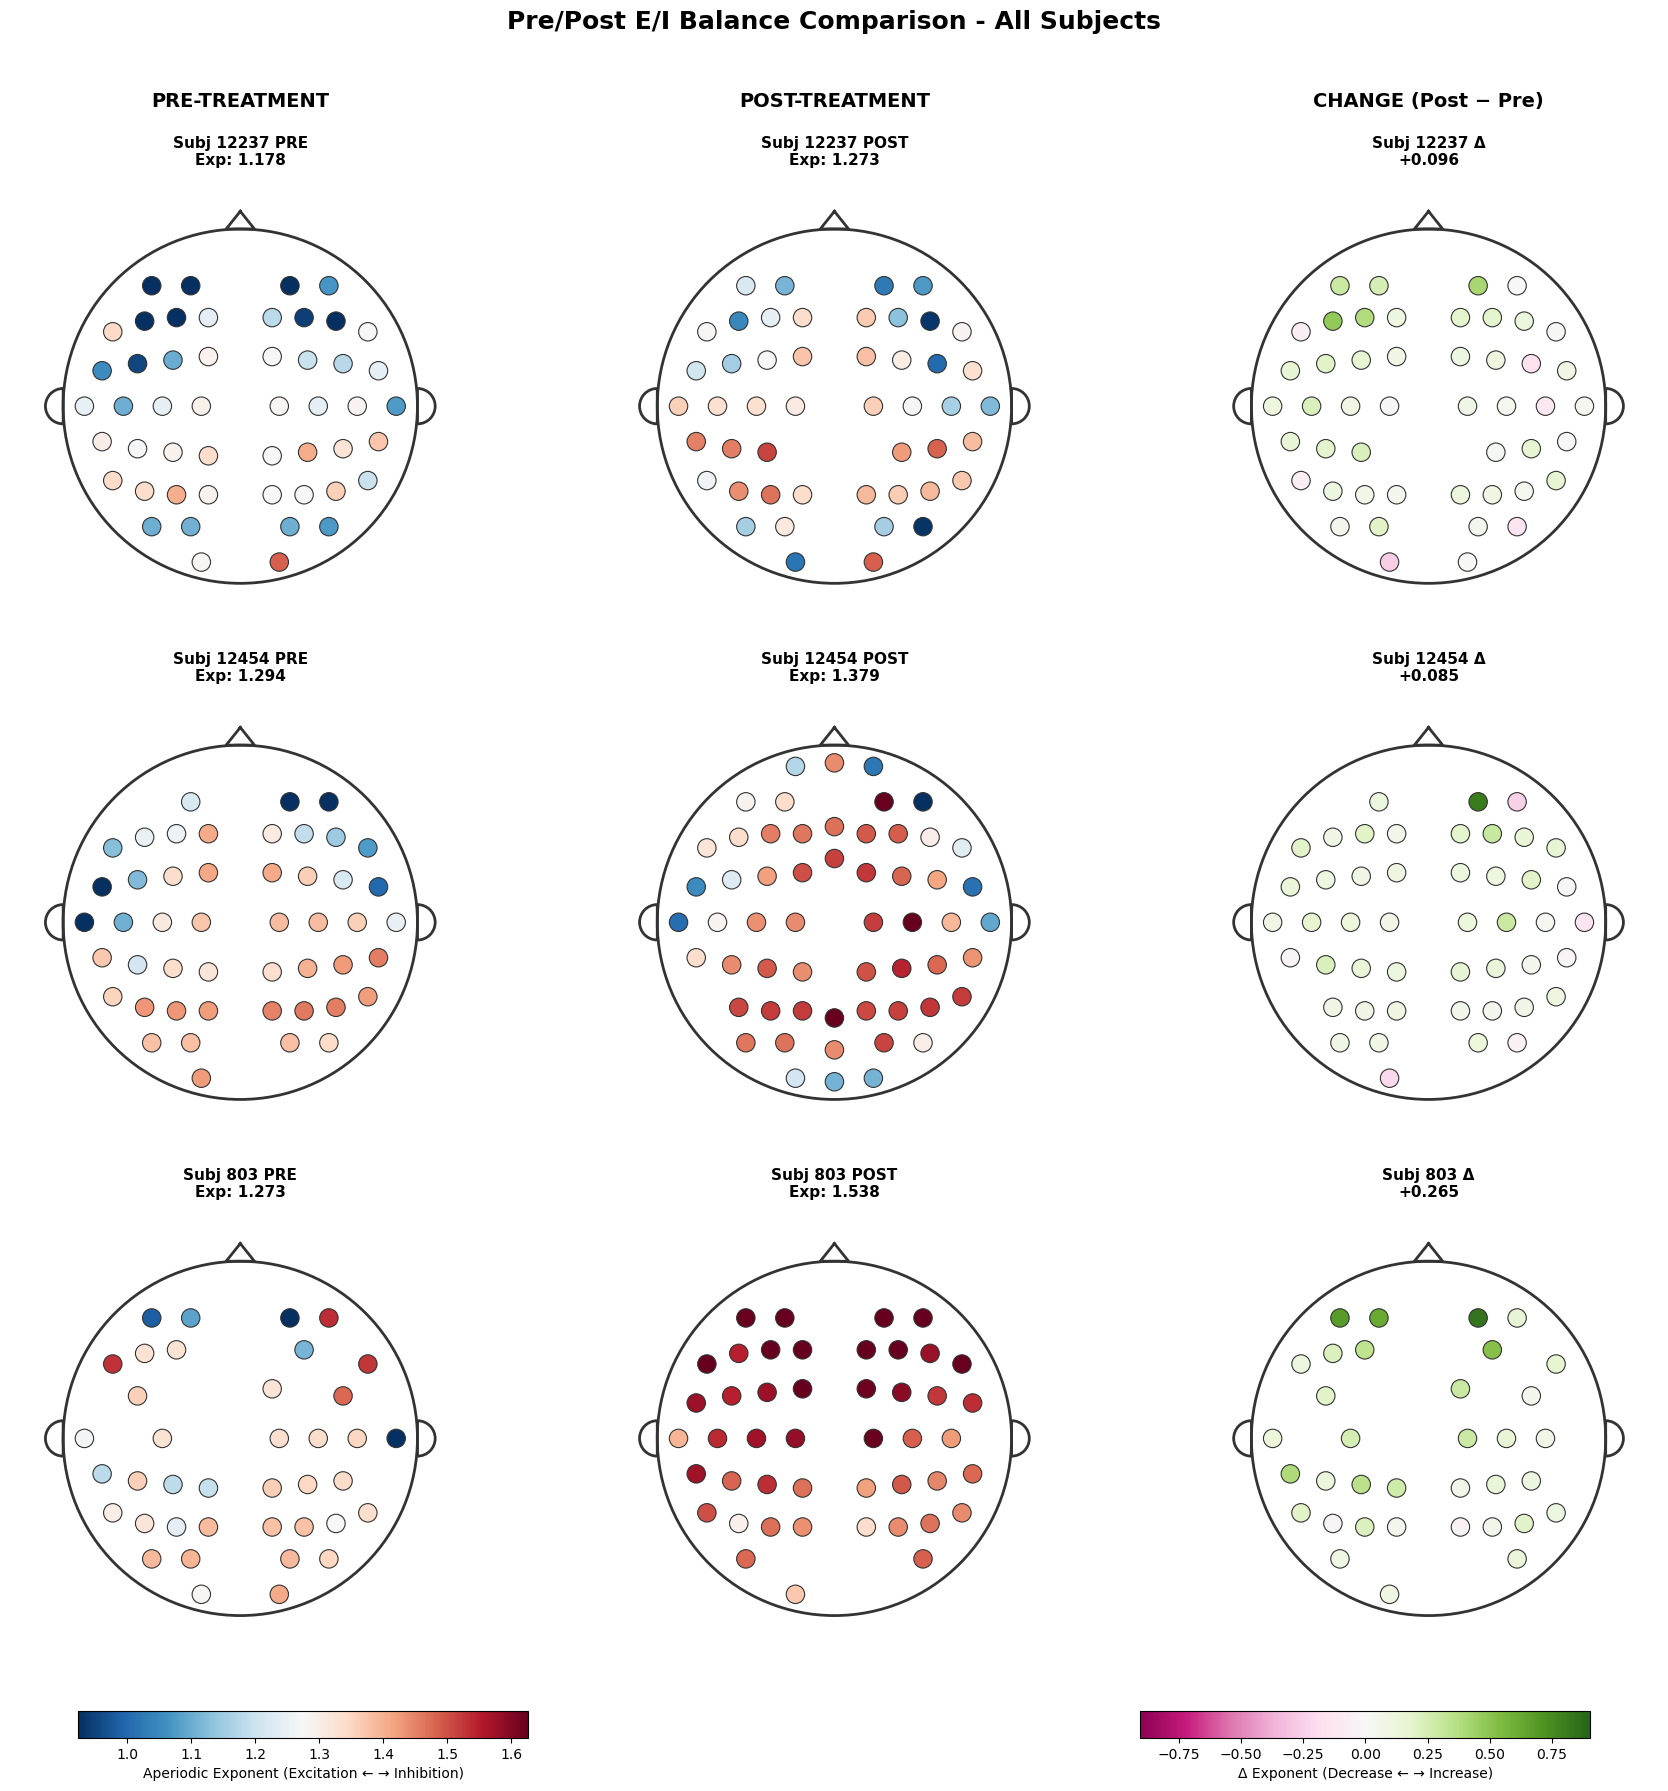

Saved: all_subjects_comparison.png


In [9]:
n_subjects = len(subject_pairs)
fig, axes = plt.subplots(n_subjects, 3, figsize=(18, 6 * n_subjects))

if n_subjects == 1:
    axes = axes.reshape(1, -1)

# Global color scales
all_vals = []
all_diffs = []
for sid, data in subject_pairs.items():
    all_vals.extend([v for v in data['pre']['channels'].values() if not np.isnan(v)])
    all_vals.extend([v for v in data['post']['channels'].values() if not np.isnan(v)])
    diff = compute_channel_difference(data['pre']['channels'], data['post']['channels'])
    all_diffs.extend([v for v in diff.values() if not np.isnan(v)])

vmin_abs = np.percentile(all_vals, 5) if all_vals else 1.0
vmax_abs = np.percentile(all_vals, 95) if all_vals else 2.0
max_diff = max(abs(min(all_diffs)), abs(max(all_diffs))) if all_diffs else 0.3
vmin_diff, vmax_diff = -max_diff, max_diff

for row, (sid, data) in enumerate(subject_pairs.items()):
    pre_data = data['pre']
    post_data = data['post']
    diff_channels = compute_channel_difference(pre_data['channels'], post_data['channels'])
    
    plot_topo(pre_data['channels'], 
              title=f"Subj {sid} PRE\nExp: {pre_data['global_exp']:.3f}",
              vmin=vmin_abs, vmax=vmax_abs, ax=axes[row, 0], show_regions=False)
    
    plot_topo(post_data['channels'], 
              title=f"Subj {sid} POST\nExp: {post_data['global_exp']:.3f}",
              vmin=vmin_abs, vmax=vmax_abs, ax=axes[row, 1], show_regions=False)
    
    delta = post_data['global_exp'] - pre_data['global_exp']
    plot_topo(diff_channels, 
              title=f"Subj {sid} Δ\n{delta:+.3f}",
              vmin=vmin_diff, vmax=vmax_diff, ax=axes[row, 2], cmap='PiYG', 
              diverging=True, center=0, show_regions=False)

# Column headers
axes[0, 0].annotate('PRE-TREATMENT', xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=14, fontweight='bold', ha='center')
axes[0, 1].annotate('POST-TREATMENT', xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=14, fontweight='bold', ha='center')
axes[0, 2].annotate('CHANGE (Post − Pre)', xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=14, fontweight='bold', ha='center')

# Shared colorbars
sm1 = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=Normalize(vmin=vmin_abs, vmax=vmax_abs))
cbar1_ax = fig.add_axes([0.08, 0.02, 0.25, 0.015])
cbar1 = fig.colorbar(sm1, cax=cbar1_ax, orientation='horizontal')
cbar1.set_label('Aperiodic Exponent (Excitation ← → Inhibition)', fontsize=10)

sm2 = plt.cm.ScalarMappable(cmap=plt.cm.PiYG, norm=TwoSlopeNorm(vmin=vmin_diff, vcenter=0, vmax=vmax_diff))
cbar2_ax = fig.add_axes([0.67, 0.02, 0.25, 0.015])
cbar2 = fig.colorbar(sm2, cax=cbar2_ax, orientation='horizontal')
cbar2.set_label('Δ Exponent (Decrease ← → Increase)', fontsize=10)

plt.suptitle('Pre/Post E/I Balance Comparison - All Subjects', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.savefig(OUTPUT_DIR / 'all_subjects_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: all_subjects_comparison.png')

---
## Spaghetti Plot: Individual Pre→Post Trajectories (Exponent)

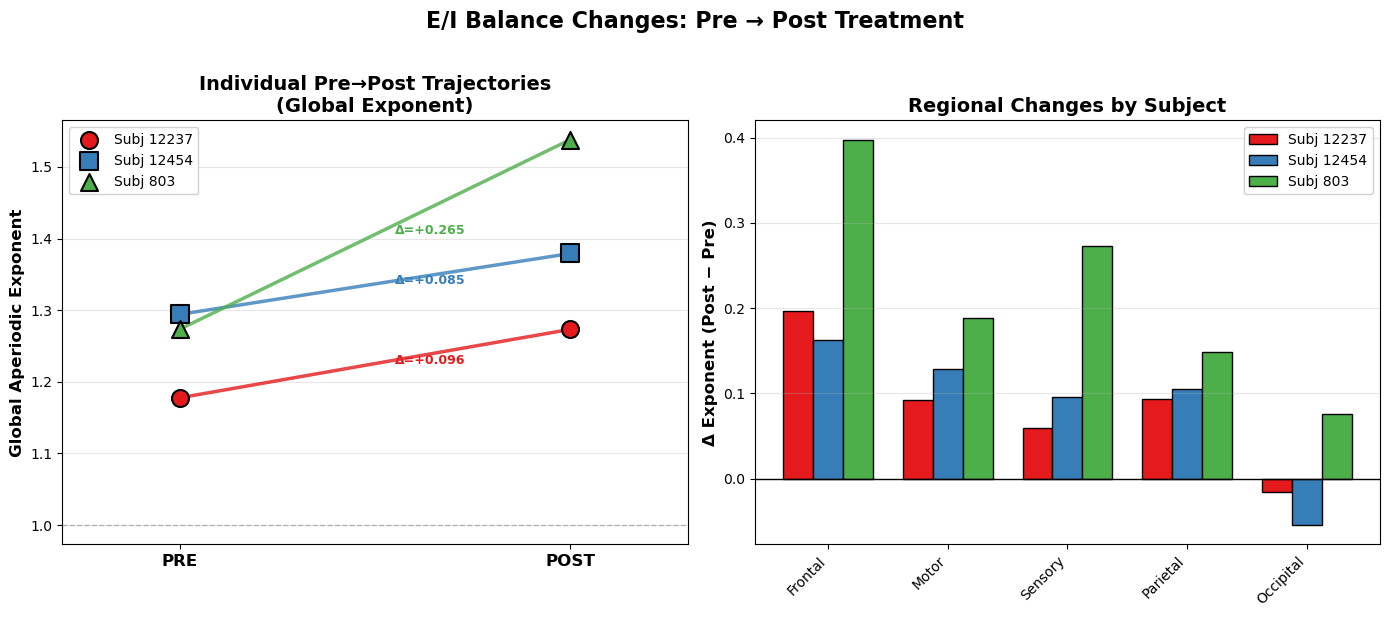

Saved: spaghetti_exponent.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Global exponent spaghetti
ax = axes[0]
for sid, data in subject_pairs.items():
    pre_val = data['pre']['global_exp']
    post_val = data['post']['global_exp']
    color = SUBJECT_COLORS.get(sid, '#666666')
    marker = SUBJECT_MARKERS.get(sid, 'o')
    
    ax.plot([0, 1], [pre_val, post_val], color=color, linewidth=2.5, alpha=0.8, zorder=2)
    ax.scatter([0], [pre_val], c=color, s=150, marker=marker, edgecolors='black', 
               linewidths=1.5, zorder=3, label=f'Subj {sid}')
    ax.scatter([1], [post_val], c=color, s=150, marker=marker, edgecolors='black', 
               linewidths=1.5, zorder=3)
    
    delta = post_val - pre_val
    mid_y = (pre_val + post_val) / 2
    ax.annotate(f'Δ={delta:+.3f}', xy=(0.55, mid_y), fontsize=9, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_xticklabels(['PRE', 'POST'], fontsize=12, fontweight='bold')
ax.set_ylabel('Global Aperiodic Exponent', fontsize=12, fontweight='bold')
ax.set_title('Individual Pre→Post Trajectories\n(Global Exponent)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(-0.3, 1.3)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Right: Regional changes grouped bar
ax = axes[1]
regions = list(BRAIN_LOBES.keys())
x = np.arange(len(regions))
width = 0.25

for i, (sid, data) in enumerate(subject_pairs.items()):
    deltas = []
    for region in regions:
        pre_val = data['pre']['lobes'].get(region, np.nan)
        post_val = data['post']['lobes'].get(region, np.nan)
        if not np.isnan(pre_val) and not np.isnan(post_val):
            deltas.append(post_val - pre_val)
        else:
            deltas.append(np.nan)
    
    color = SUBJECT_COLORS.get(sid, '#666666')
    offset = (i - len(subject_pairs)/2 + 0.5) * width
    ax.bar(x + offset, deltas, width, label=f'Subj {sid}', color=color, edgecolor='black', linewidth=1)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Δ Exponent (Post − Pre)', fontsize=12, fontweight='bold')
ax.set_title('Regional Changes by Subject', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('E/I Balance Changes: Pre → Post Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spaghetti_exponent.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: spaghetti_exponent.png')

---
## Spaghetti Plot: Individual Pre→Post Trajectories (Offset)

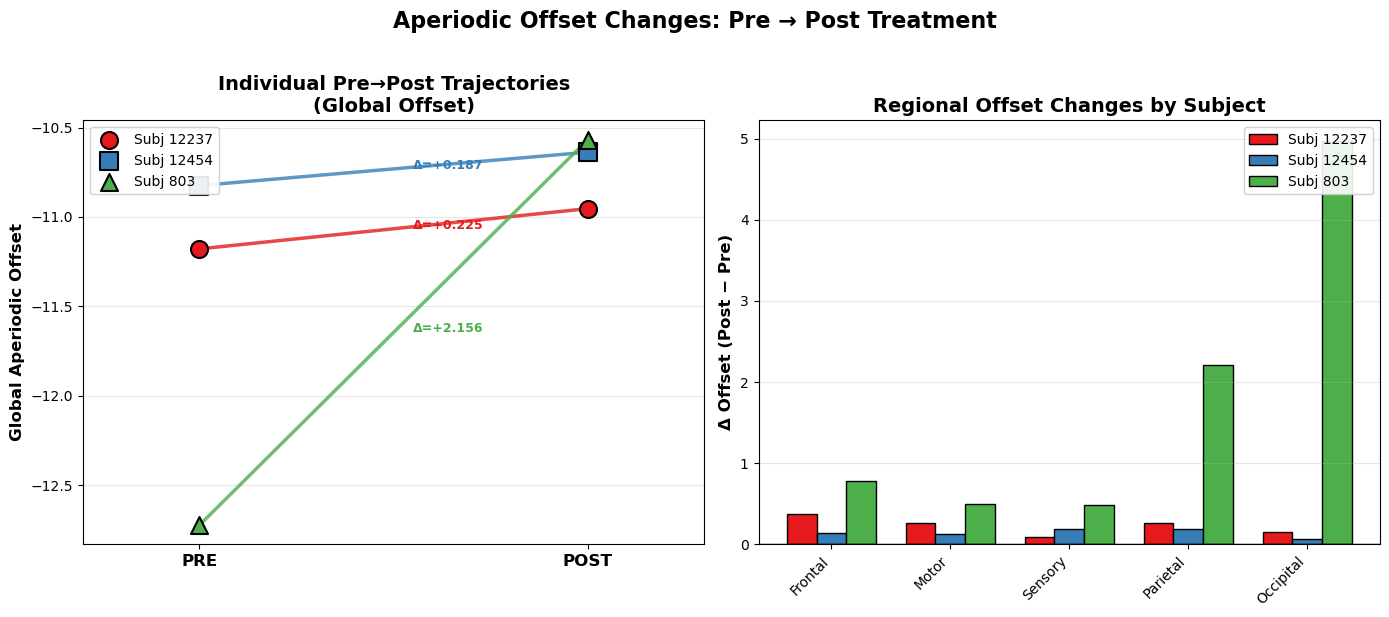

Saved: spaghetti_offset.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Global offset spaghetti
ax = axes[0]
for sid, data in subject_pairs.items():
    pre_val = data['pre']['global_off']
    post_val = data['post']['global_off']
    color = SUBJECT_COLORS.get(sid, '#666666')
    marker = SUBJECT_MARKERS.get(sid, 'o')
    
    ax.plot([0, 1], [pre_val, post_val], color=color, linewidth=2.5, alpha=0.8, zorder=2)
    ax.scatter([0], [pre_val], c=color, s=150, marker=marker, edgecolors='black', 
               linewidths=1.5, zorder=3, label=f'Subj {sid}')
    ax.scatter([1], [post_val], c=color, s=150, marker=marker, edgecolors='black', 
               linewidths=1.5, zorder=3)
    
    delta = post_val - pre_val
    mid_y = (pre_val + post_val) / 2
    ax.annotate(f'Δ={delta:+.3f}', xy=(0.55, mid_y), fontsize=9, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_xticklabels(['PRE', 'POST'], fontsize=12, fontweight='bold')
ax.set_ylabel('Global Aperiodic Offset', fontsize=12, fontweight='bold')
ax.set_title('Individual Pre→Post Trajectories\n(Global Offset)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(-0.3, 1.3)

# Right: Regional offset changes
ax = axes[1]
regions = list(BRAIN_LOBES.keys())
x = np.arange(len(regions))
width = 0.25

for i, (sid, data) in enumerate(subject_pairs.items()):
    deltas = []
    for region in regions:
        pre_val = data['pre']['lobe_off'].get(region, np.nan)
        post_val = data['post']['lobe_off'].get(region, np.nan)
        if not np.isnan(pre_val) and not np.isnan(post_val):
            deltas.append(post_val - pre_val)
        else:
            deltas.append(np.nan)
    
    color = SUBJECT_COLORS.get(sid, '#666666')
    offset = (i - len(subject_pairs)/2 + 0.5) * width
    ax.bar(x + offset, deltas, width, label=f'Subj {sid}', color=color, edgecolor='black', linewidth=1)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Δ Offset (Post − Pre)', fontsize=12, fontweight='bold')
ax.set_title('Regional Offset Changes by Subject', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Aperiodic Offset Changes: Pre → Post Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spaghetti_offset.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: spaghetti_offset.png')

---
## Difference Summary: Change Magnitude Across Subjects

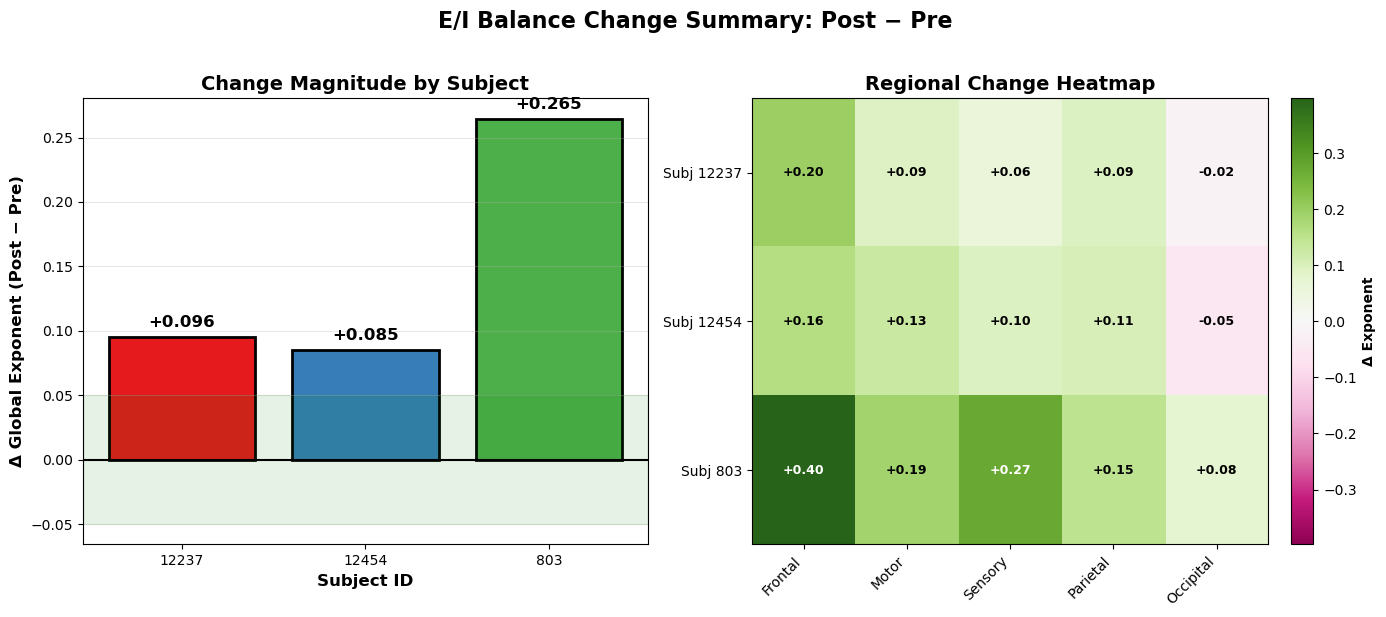

Saved: difference_summary.png


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Global change bar chart
ax = axes[0]
subjects = list(subject_pairs.keys())
deltas = [subject_pairs[sid]['post']['global_exp'] - subject_pairs[sid]['pre']['global_exp'] for sid in subjects]
colors = [SUBJECT_COLORS.get(sid, '#666666') for sid in subjects]

bars = ax.bar(subjects, deltas, color=colors, edgecolor='black', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

for bar, delta in zip(bars, deltas):
    height = bar.get_height()
    ax.annotate(f'{delta:+.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=12, fontweight='bold')

ax.set_xlabel('Subject ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Δ Global Exponent (Post − Pre)', fontsize=12, fontweight='bold')
ax.set_title('Change Magnitude by Subject', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhspan(-0.05, 0.05, alpha=0.1, color='green', label='Minimal change')

# Right: Regional heatmap
ax = axes[1]
regions = list(BRAIN_LOBES.keys())

change_matrix = np.zeros((len(subjects), len(regions)))
for i, sid in enumerate(subjects):
    for j, region in enumerate(regions):
        pre_val = subject_pairs[sid]['pre']['lobes'].get(region, np.nan)
        post_val = subject_pairs[sid]['post']['lobes'].get(region, np.nan)
        if not np.isnan(pre_val) and not np.isnan(post_val):
            change_matrix[i, j] = post_val - pre_val
        else:
            change_matrix[i, j] = np.nan

max_abs = np.nanmax(np.abs(change_matrix))
im = ax.imshow(change_matrix, cmap='PiYG', vmin=-max_abs, vmax=max_abs, aspect='auto')

ax.set_xticks(np.arange(len(regions)))
ax.set_xticklabels(regions, rotation=45, ha='right', fontsize=10)
ax.set_yticks(np.arange(len(subjects)))
ax.set_yticklabels([f'Subj {s}' for s in subjects], fontsize=10)

for i in range(len(subjects)):
    for j in range(len(regions)):
        val = change_matrix[i, j]
        if not np.isnan(val):
            text_color = 'white' if abs(val) > max_abs * 0.6 else 'black'
            ax.text(j, i, f'{val:+.2f}', ha='center', va='center', 
                   fontsize=9, color=text_color, fontweight='bold')

ax.set_title('Regional Change Heatmap', fontsize=14, fontweight='bold')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Δ Exponent', fontsize=10, fontweight='bold')

plt.suptitle('E/I Balance Change Summary: Post − Pre', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'difference_summary.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: difference_summary.png')

---
## Summary Tables

In [13]:
# Full summary
rows = []
for name, data in results.items():
    row = {
        'File': name,
        'Subject': data['info']['subject_id'],
        'Condition': data['info']['condition'].upper(),
        'Variant': data['info']['variant'],
        'Global_Exp': data['global_exp'],
        'Global_Off': data['global_off'],
    }
    row.update({f"{k}_Exp": v for k, v in data['lobes'].items()})
    rows.append(row)

df = pd.DataFrame(rows).round(4)
df.to_csv(OUTPUT_DIR / 'exponent_summary_enhanced.csv', index=False)
print('Saved: exponent_summary_enhanced.csv')
display(df)

Saved: exponent_summary_enhanced.csv


,File,Subject,Condition,Variant,Global_Exp,Global_Off,Frontal_Exp,Motor_Exp,Sensory_Exp,Parietal_Exp,Occipital_Exp
0,TReC_12237_preEEG_EI,12237,PRE,standard,1.1777,-11.1784,0.9740,1.1606,1.2206,1.3150,1.1921
1,TReC_12454_PostEEG_EI_notimestamps (1),12454,POST,notimestamps,1.3693,-10.6461,1.3163,1.3378,1.3363,1.4885,1.3215
2,TReC_12454_postEEG_EI,12454,POST,standard,1.3791,-10.6378,1.3232,1.3495,1.3560,1.4970,1.3261
3,TReC_12454_preEEG_EI,12454,PRE,standard,1.2941,-10.8244,1.1605,1.2211,1.2600,1.3918,1.3808
4,TReC_12454_preEEG_EI_nooffset,12454,PRE,nooffset,1.2157,-10.6462,1.2853,1.1744,1.1353,1.2644,1.1359
5,TReC_803_PreEEG,803,PRE,standard,1.7129,-10.0651,1.8614,1.3850,1.2539,1.7860,2.0676
6,TReC_803_postEEG_EI,803,POST,standard,1.5380,-10.5675,1.6447,1.5743,1.5177,1.4545,1.4439
7,TReC_803_preEEG_EI,803,PRE,standard,1.2733,-12.7230,1.2468,1.3859,1.2447,1.3055,1.3676
8,TRec_12237_EI_post,12237,POST,standard,1.2732,-10.9533,1.1704,1.2528,1.2803,1.4088,1.1759


In [14]:
# Pre/Post change summary
change_rows = []
for sid, data in subject_pairs.items():
    pre_exp = data['pre']['global_exp']
    post_exp = data['post']['global_exp']
    pre_off = data['pre']['global_off']
    post_off = data['post']['global_off']
    
    change_rows.append({
        'Subject': sid,
        'Pre_Exp': pre_exp,
        'Post_Exp': post_exp,
        'Δ_Exp': post_exp - pre_exp,
        'Pre_Off': pre_off,
        'Post_Off': post_off,
        'Δ_Off': post_off - pre_off,
    })

df_changes = pd.DataFrame(change_rows).round(4)
df_changes.to_csv(OUTPUT_DIR / 'pre_post_changes.csv', index=False)
print('Saved: pre_post_changes.csv')
display(df_changes)

Saved: pre_post_changes.csv


,Subject,Pre_Exp,Post_Exp,Δ_Exp,Pre_Off,Post_Off,Δ_Off
0,12237,1.1777,1.2732,0.0956,-11.1784,-10.9533,0.2251
1,12454,1.2941,1.3791,0.0850,-10.8244,-10.6378,0.1866
2,803,1.2733,1.5380,0.2647,-12.7230,-10.5675,2.1555


In [15]:
print(f'\n=== ANALYSIS COMPLETE ===')
print(f'Outputs saved to: {OUTPUT_DIR}')


=== ANALYSIS COMPLETE ===
Outputs saved to: /Users/manasapooni/Downloads/TReC_EI_Cleaned/Analysis_Output_Enhanced
